In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten

In [2]:
bdf = pd.read_csv("christchurch_data.csv") #read origin file
print(bdf.columns)

Index(['Date', 'Daily Average CO (mg/m3)', 'Daily Average NO (ug/m3)',
       'Daily Average NO2 (ug/m3)', 'Daily Average SO2 (ug/m3)',
       'Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)',
       'WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)',
       'Rain(mm)', 'Tdry(C)', 'TWet(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)',
       'Tgmin(C)', 'ET05(C)', 'ET10(C)', 'ET20(C)', 'ET30(C)', 'ET100(C)',
       'Pmsl(hPa)', 'Pstn(hPa)', 'Sun(Hrs)', 'Rad(MJ/m2)', 'lightCount',
       'heavyCount'],
      dtype='object')


In [3]:
bdf = bdf.drop(['ET05(C)', 'ET30(C)'], axis=1)
print(bdf.columns)

Index(['Date', 'Daily Average CO (mg/m3)', 'Daily Average NO (ug/m3)',
       'Daily Average NO2 (ug/m3)', 'Daily Average SO2 (ug/m3)',
       'Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)',
       'WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)',
       'Rain(mm)', 'Tdry(C)', 'TWet(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)',
       'Tgmin(C)', 'ET10(C)', 'ET20(C)', 'ET100(C)', 'Pmsl(hPa)', 'Pstn(hPa)',
       'Sun(Hrs)', 'Rad(MJ/m2)', 'lightCount', 'heavyCount'],
      dtype='object')


In [4]:
bdf = bdf.drop(['Tgmin(C)', 'ET10(C)','ET20(C)','ET100(C)'], axis=1)
print(bdf)

            Date  Daily Average CO (mg/m3)  Daily Average NO (ug/m3)  \
0     2020-01-01                  0.246304                 29.073479   
1     2020-01-02                  0.271630                 25.823044   
2     2020-01-03                  0.251587                 32.285652   
3     2020-01-04                  0.101152                 12.457826   
4     2020-01-05                  0.153565                 15.993478   
...          ...                       ...                       ...   
1456  2023-12-27                  0.295075                 24.265690   
1457  2023-12-28                  0.260637                 17.952810   
1458  2023-12-29                  0.318159                 17.682569   
1459  2023-12-30                  0.276525                 13.043710   
1460  2023-12-31                  0.244744                  5.722939   

      Daily Average NO2 (ug/m3)  Daily Average SO2 (ug/m3)  \
0                     21.320869                   2.464783   
1          

In [5]:
bdf = bdf.drop(['Sun(Hrs)'], axis=1)

C:\Users\morga\AppData\Local\Temp\ipykernel_16936\632057461.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = bdf.corr()


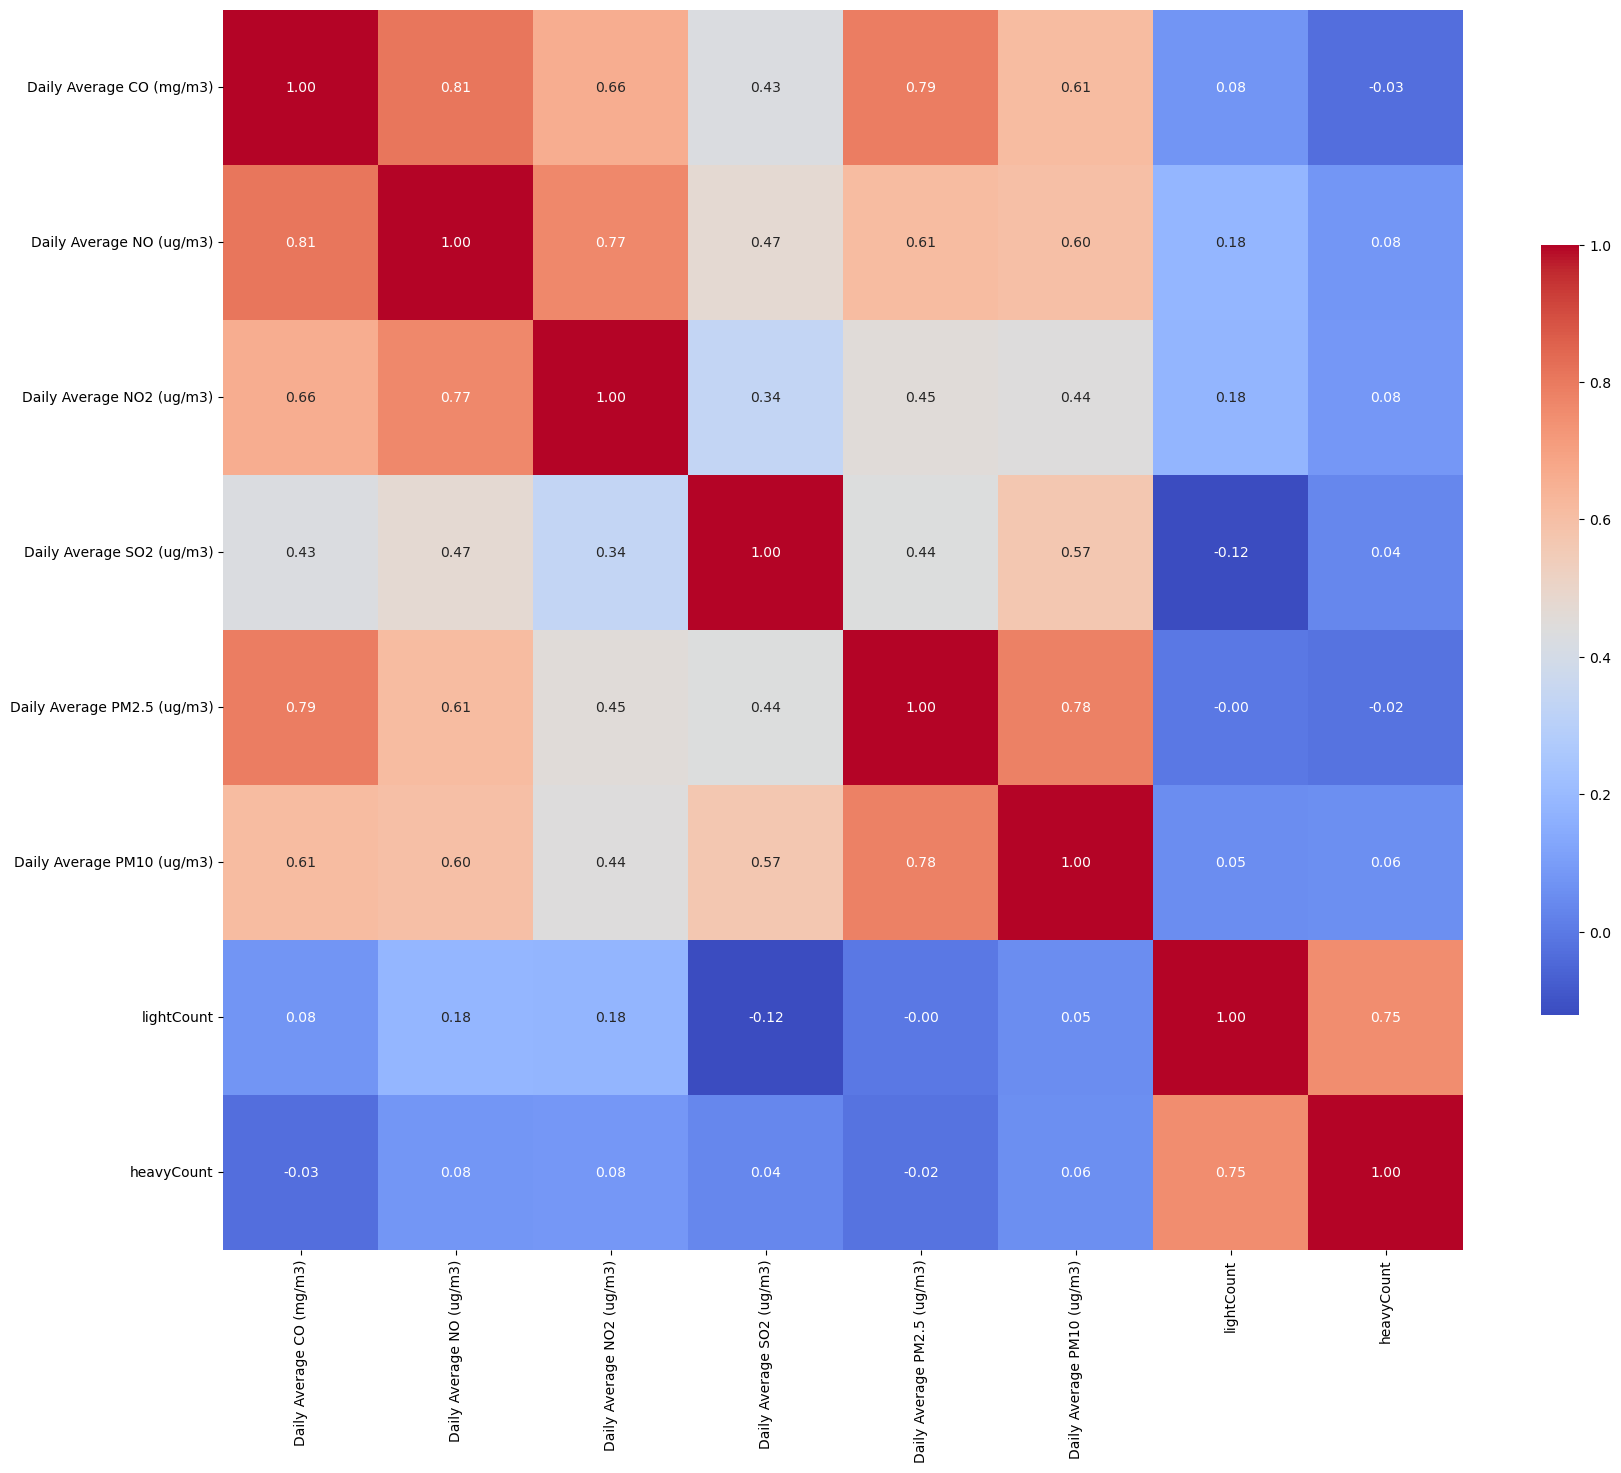

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = bdf.corr()


plt.figure(figsize=(20, 20))


sns.heatmap(corr, annot=True, fmt=".2f", square=True, cmap='coolwarm', cbar_kws={"shrink": .5})


plt.show()


In [7]:
bdf['Date'] = pd.to_datetime(bdf['Date'], format='%Y/%m/%d')
print(bdf)

           Date  Daily Average CO (mg/m3)  Daily Average NO (ug/m3)  \
0    2020-01-01                  0.246304                 29.073479   
1    2020-01-02                  0.271630                 25.823044   
2    2020-01-03                  0.251587                 32.285652   
3    2020-01-04                  0.101152                 12.457826   
4    2020-01-05                  0.153565                 15.993478   
...         ...                       ...                       ...   
1456 2023-12-27                  0.295075                 24.265690   
1457 2023-12-28                  0.260637                 17.952810   
1458 2023-12-29                  0.318159                 17.682569   
1459 2023-12-30                  0.276525                 13.043710   
1460 2023-12-31                  0.244744                  5.722939   

      Daily Average NO2 (ug/m3)  Daily Average SO2 (ug/m3)  \
0                     21.320869                   2.464783   
1                     1

In [8]:

for col in bdf.columns:

    median = pd.to_numeric(bdf[col], errors='coerce').median()

    bdf[col] = pd.to_numeric(bdf[col], errors='coerce').fillna(median)

In [9]:
print(bdf['Date'])

0       1577836800000000000
1       1577923200000000000
2       1578009600000000000
3       1578096000000000000
4       1578182400000000000
               ...         
1456    1703635200000000000
1457    1703721600000000000
1458    1703808000000000000
1459    1703894400000000000
1460    1703980800000000000
Name: Date, Length: 1461, dtype: int64


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1

bdf['Date'] = pd.to_datetime(bdf['Date'], format='%Y/%m/%d')

bdf['Date'] = bdf['Date'].apply(lambda x: x.value) 

features = bdf.drop(columns=['Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)'])
target = bdf[['Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)']]


input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = input_scaler.fit_transform(features)


output_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = output_scaler.fit_transform(target)

import joblib
joblib.dump(input_scaler, 'Christ_input_scaler2.pkl')
joblib.dump(output_scaler, 'Christ_output_scaler2.pkl')
                              
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))




In [11]:
print(bdf)

                     Date  Daily Average CO (mg/m3)  Daily Average NO (ug/m3)  \
0     1577836800000000000                  0.246304                 29.073479   
1     1577923200000000000                  0.271630                 25.823044   
2     1578009600000000000                  0.251587                 32.285652   
3     1578096000000000000                  0.101152                 12.457826   
4     1578182400000000000                  0.153565                 15.993478   
...                   ...                       ...                       ...   
1456  1703635200000000000                  0.295075                 24.265690   
1457  1703721600000000000                  0.260637                 17.952810   
1458  1703808000000000000                  0.318159                 17.682569   
1459  1703894400000000000                  0.276525                 13.043710   
1460  1703980800000000000                  0.244744                  5.722939   

      Daily Average NO2 (ug

In [12]:
from tensorflow.keras.layers import Dropout, MaxPooling1D


model = Sequential()


model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))


model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)




Epoch 1/100

37/37 - 4s - loss: 0.0156 - val_loss: 0.0105 - 4s/epoch - 106ms/step
Epoch 2/100
37/37 - 0s - loss: 0.0114 - val_loss: 0.0102 - 498ms/epoch - 13ms/step
Epoch 3/100
37/37 - 1s - loss: 0.0102 - val_loss: 0.0089 - 537ms/epoch - 15ms/step
Epoch 4/100
37/37 - 1s - loss: 0.0099 - val_loss: 0.0084 - 601ms/epoch - 16ms/step
Epoch 5/100
37/37 - 1s - loss: 0.0092 - val_loss: 0.0077 - 626ms/epoch - 17ms/step
Epoch 6/100
37/37 - 1s - loss: 0.0094 - val_loss: 0.0075 - 507ms/epoch - 14ms/step
Epoch 7/100
37/37 - 1s - loss: 0.0090 - val_loss: 0.0073 - 558ms/epoch - 15ms/step
Epoch 8/100
37/37 - 1s - loss: 0.0084 - val_loss: 0.0074 - 582ms/epoch - 16ms/step
Epoch 9/100
37/37 - 1s - loss: 0.0080 - val_loss: 0.0070 - 572ms/epoch - 15ms/step
Epoch 10/100
37/37 - 0s - loss: 0.0082 - val_loss: 0.0069 - 452ms/epoch - 12ms/step
Epoch 11/100
37/37 - 0s - loss: 0.0081 - val_loss: 0.0075 - 465ms/epoch - 13ms/step
Epoch 12/100
37/37 - 1s - loss: 0.0074 - val_loss: 0.0065 - 657ms/epoch - 18ms/step

37/37 - 0s - loss: 0.0038 - val_loss: 0.0056 - 404ms/epoch - 11ms/step
Epoch 91/100
37/37 - 0s - loss: 0.0039 - val_loss: 0.0054 - 493ms/epoch - 13ms/step
Epoch 92/100
37/37 - 1s - loss: 0.0039 - val_loss: 0.0053 - 696ms/epoch - 19ms/step
Epoch 93/100
37/37 - 1s - loss: 0.0040 - val_loss: 0.0054 - 697ms/epoch - 19ms/step
Epoch 94/100
37/37 - 1s - loss: 0.0038 - val_loss: 0.0052 - 647ms/epoch - 17ms/step
Epoch 95/100
37/37 - 1s - loss: 0.0039 - val_loss: 0.0054 - 639ms/epoch - 17ms/step
Epoch 96/100
37/37 - 1s - loss: 0.0041 - val_loss: 0.0054 - 635ms/epoch - 17ms/step
Epoch 97/100
37/37 - 1s - loss: 0.0040 - val_loss: 0.0054 - 636ms/epoch - 17ms/step
Epoch 98/100
37/37 - 1s - loss: 0.0038 - val_loss: 0.0055 - 691ms/epoch - 19ms/step
Epoch 99/100
37/37 - 1s - loss: 0.0039 - val_loss: 0.0054 - 672ms/epoch - 18ms/step
Epoch 100/100
37/37 - 1s - loss: 0.0039 - val_loss: 0.0053 - 674ms/epoch - 18ms/step


In [13]:
print(bdf.columns.tolist())

['Date', 'Daily Average CO (mg/m3)', 'Daily Average NO (ug/m3)', 'Daily Average NO2 (ug/m3)', 'Daily Average SO2 (ug/m3)', 'Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)', 'WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)', 'Rain(mm)', 'Tdry(C)', 'TWet(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)', 'Pmsl(hPa)', 'Pstn(hPa)', 'Rad(MJ/m2)', 'lightCount', 'heavyCount']


In [14]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.005265998654067516


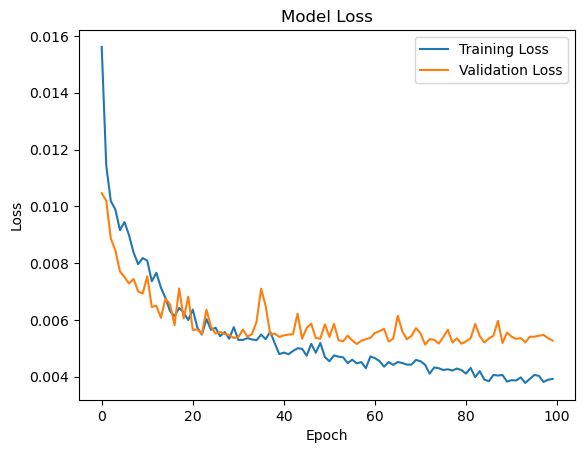

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

10/10 [==============================] - 0s 7ms/step


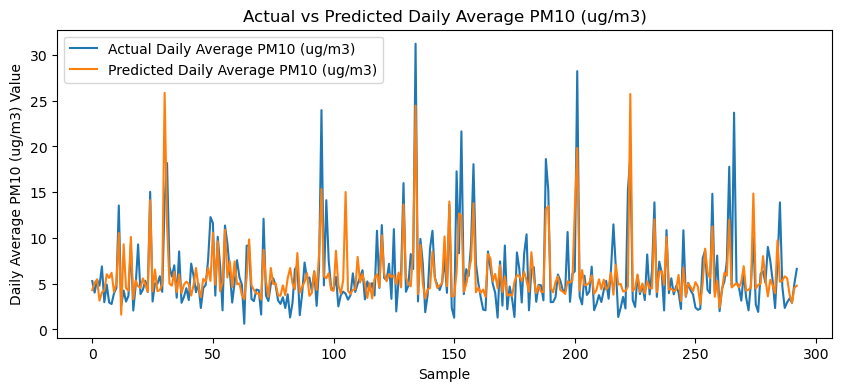

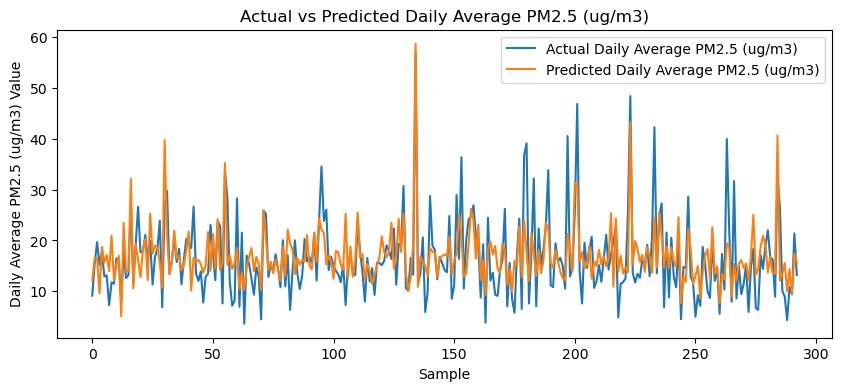

In [16]:

predictions = model.predict(X_test)


predictions_inversed = output_scaler.inverse_transform(predictions)
y_test_inversed = output_scaler.inverse_transform(y_test)


target_labels = ['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)', 'Daily Average AQI']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel(f'{target_labels[i]} Value')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def analyze_rnn_model(model, X_train, y_train, X_test, y_test):

    model.summary()


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Train MSE: {train_mse}")
    print(f"Test MSE: {test_mse}")
    print(f"Train R2 Score: {train_r2}")
    print(f"Test R2 Score: {test_r2}")


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Train Set')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Test Set')
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0

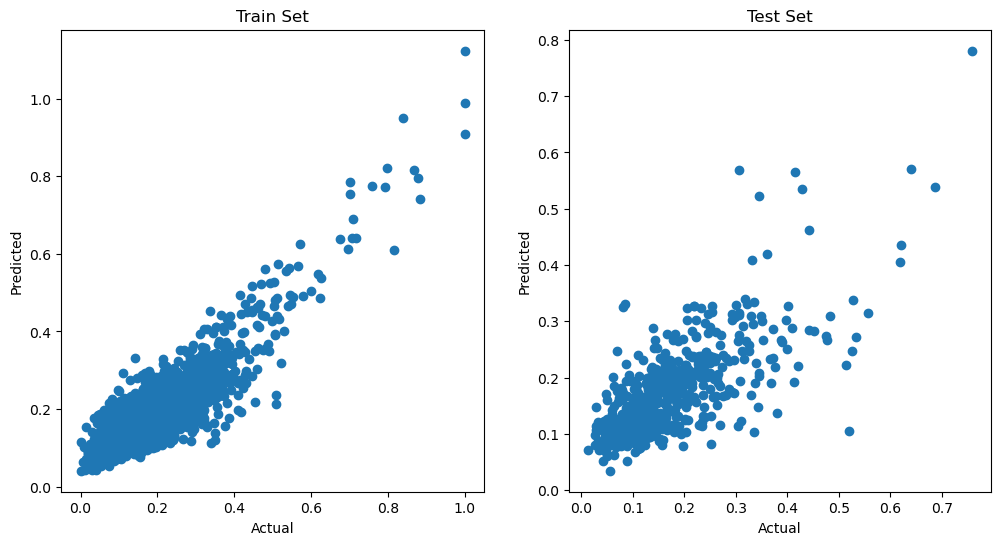

In [19]:
analyze_rnn_model(model, X_train, y_train, X_test, y_test)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))


    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))


    model.add(LSTM(60, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))


    model.add(Dense(2))


    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


model = build_model()

history = model.fit(X_train, y_train, epochs=80, batch_size=27, validation_data=(X_test, y_test), verbose=2)

Epoch 1/80
44/44 - 4s - loss: 0.0155 - val_loss: 0.0106 - 4s/epoch - 84ms/step
Epoch 2/80
44/44 - 1s - loss: 0.0113 - val_loss: 0.0080 - 746ms/epoch - 17ms/step
Epoch 3/80
44/44 - 1s - loss: 0.0104 - val_loss: 0.0092 - 779ms/epoch - 18ms/step
Epoch 4/80
44/44 - 1s - loss: 0.0099 - val_loss: 0.0076 - 749ms/epoch - 17ms/step
Epoch 5/80
44/44 - 1s - loss: 0.0093 - val_loss: 0.0073 - 741ms/epoch - 17ms/step
Epoch 6/80
44/44 - 1s - loss: 0.0089 - val_loss: 0.0073 - 768ms/epoch - 17ms/step
Epoch 7/80
44/44 - 1s - loss: 0.0087 - val_loss: 0.0075 - 611ms/epoch - 14ms/step
Epoch 8/80
44/44 - 1s - loss: 0.0089 - val_loss: 0.0085 - 727ms/epoch - 17ms/step
Epoch 9/80
44/44 - 1s - loss: 0.0083 - val_loss: 0.0072 - 719ms/epoch - 16ms/step
Epoch 10/80
44/44 - 1s - loss: 0.0079 - val_loss: 0.0070 - 733ms/epoch - 17ms/step
Epoch 11/80
44/44 - 1s - loss: 0.0076 - val_loss: 0.0075 - 784ms/epoch - 18ms/step
Epoch 12/80
44/44 - 1s - loss: 0.0077 - val_loss: 0.0068 - 756ms/epoch - 17ms/step
Epoch 13/80
44/4

10/10 [==============================] - 0s 7ms/step


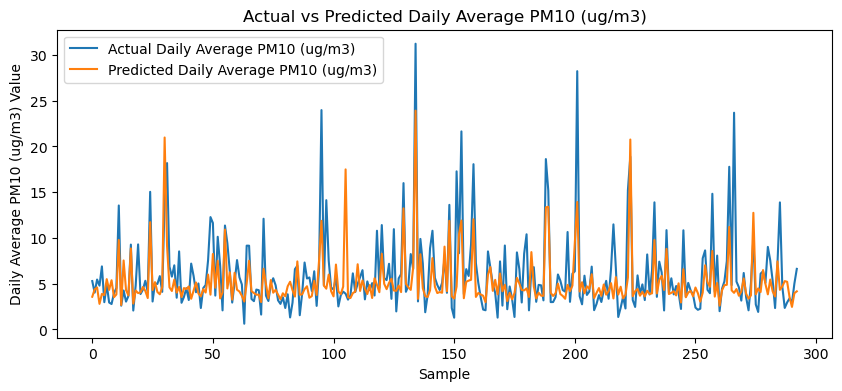

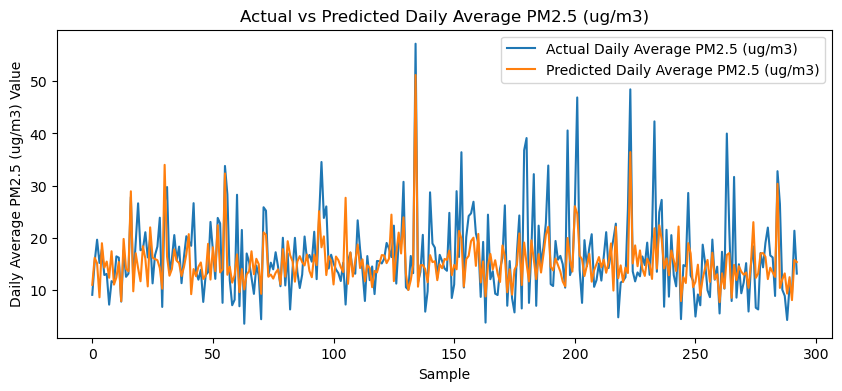

In [21]:

predictions = model.predict(X_test)


predictions_inversed = output_scaler.inverse_transform(predictions)
y_test_inversed = output_scaler.inverse_transform(y_test)


target_labels = ['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)', 'Daily Average AQI']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel(f'{target_labels[i]} Value')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 19, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 9, 64)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 3, 128)           

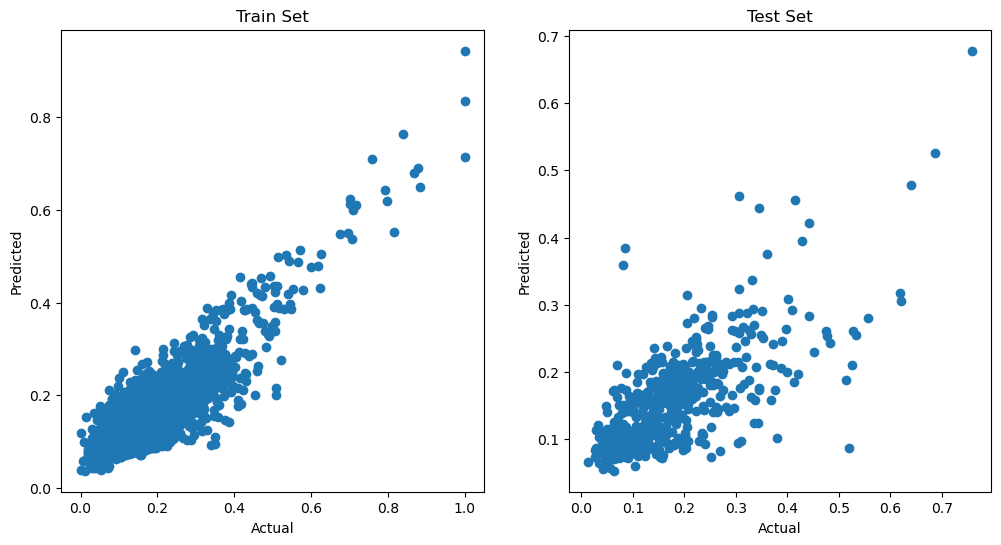

In [22]:
analyze_rnn_model(model, X_train, y_train, X_test, y_test)

In [23]:



scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target)


X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



model = Sequential()


model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))


model.add(LSTM(50, activation='relu'))


model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
37/37 - 3s - loss: 0.0139 - val_loss: 0.0094 - 3s/epoch - 77ms/step
Epoch 2/100
37/37 - 1s - loss: 0.0115 - val_loss: 0.0088 - 557ms/epoch - 15ms/step
Epoch 3/100
37/37 - 1s - loss: 0.0105 - val_loss: 0.0083 - 506ms/epoch - 14ms/step
Epoch 4/100
37/37 - 1s - loss: 0.0103 - val_loss: 0.0083 - 503ms/epoch - 14ms/step
Epoch 5/100
37/37 - 1s - loss: 0.0103 - val_loss: 0.0076 - 512ms/epoch - 14ms/step
Epoch 6/100
37/37 - 1s - loss: 0.0093 - val_loss: 0.0074 - 514ms/epoch - 14ms/step
Epoch 7/100
37/37 - 0s - loss: 0.0090 - val_loss: 0.0077 - 442ms/epoch - 12ms/step
Epoch 8/100
37/37 - 0s - loss: 0.0089 - val_loss: 0.0074 - 400ms/epoch - 11ms/step
Epoch 9/100
37/37 - 0s - loss: 0.0084 - val_loss: 0.0079 - 403ms/epoch - 11ms/step
Epoch 10/100
37/37 - 0s - loss: 0.0080 - val_loss: 0.0076 - 464ms/epoch - 13ms/step
Epoch 11/100
37/37 - 0s - loss: 0.0088 - val_loss: 0.0068 - 496ms/epoch - 13ms/step
Epoch 12/100
37/37 - 0s - loss: 0.0079 - val_loss: 0.0065 - 477ms/epoch - 13ms/step
Epoc

Epoch 99/100
37/37 - 1s - loss: 0.0040 - val_loss: 0.0049 - 524ms/epoch - 14ms/step
Epoch 100/100
37/37 - 1s - loss: 0.0039 - val_loss: 0.0052 - 505ms/epoch - 14ms/step


In [24]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.0051779188215732574


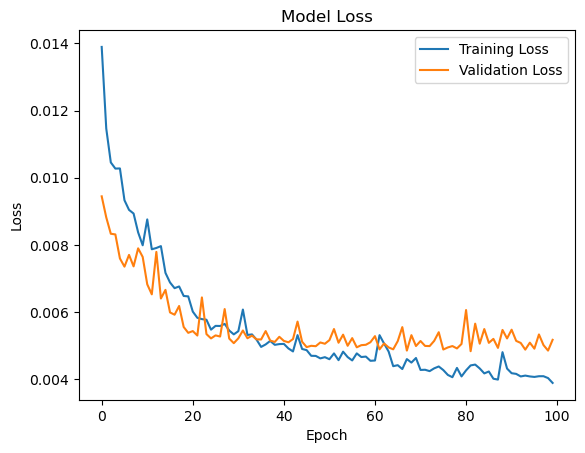

In [25]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

10/10 [==============================] - 0s 6ms/step


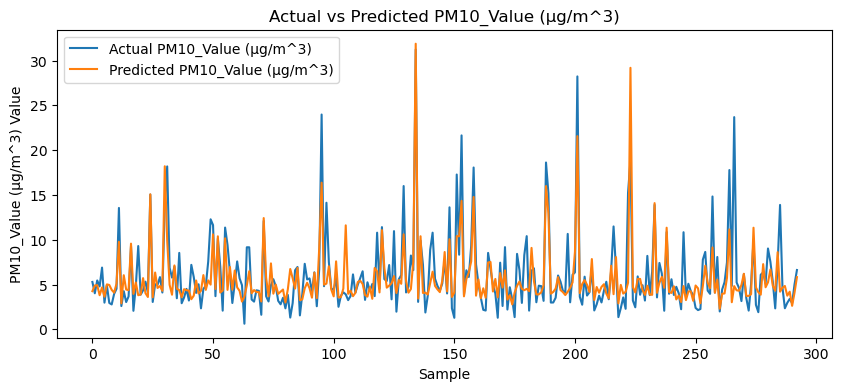

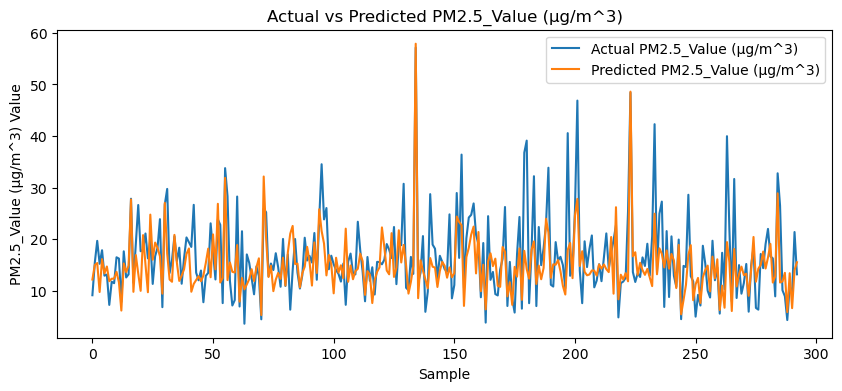

In [26]:

predictions = model.predict(X_test)


predictions_inversed = scaler.inverse_transform(predictions)
y_test_inversed = scaler.inverse_transform(y_test)


target_labels = ['PM10_Value (µg/m^3)', 'PM2.5_Value (µg/m^3)']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel(f'{target_labels[i]} Value')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))


    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

   
    model.add(LSTM(60, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(2))


    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


model = build_model()

history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
47/47 - 4s - loss: 0.0147 - val_loss: 0.0099 - 4s/epoch - 80ms/step
Epoch 2/100
47/47 - 1s - loss: 0.0109 - val_loss: 0.0085 - 925ms/epoch - 20ms/step
Epoch 3/100
47/47 - 1s - loss: 0.0102 - val_loss: 0.0087 - 808ms/epoch - 17ms/step
Epoch 4/100
47/47 - 1s - loss: 0.0097 - val_loss: 0.0080 - 822ms/epoch - 17ms/step
Epoch 5/100
47/47 - 1s - loss: 0.0096 - val_loss: 0.0074 - 850ms/epoch - 18ms/step
Epoch 6/100
47/47 - 1s - loss: 0.0091 - val_loss: 0.0075 - 814ms/epoch - 17ms/step
Epoch 7/100
47/47 - 1s - loss: 0.0094 - val_loss: 0.0077 - 844ms/epoch - 18ms/step
Epoch 8/100
47/47 - 1s - loss: 0.0086 - val_loss: 0.0073 - 849ms/epoch - 18ms/step
Epoch 9/100
47/47 - 1s - loss: 0.0080 - val_loss: 0.0072 - 819ms/epoch - 17ms/step
Epoch 10/100
47/47 - 1s - loss: 0.0080 - val_loss: 0.0069 - 793ms/epoch - 17ms/step
Epoch 11/100
47/47 - 1s - loss: 0.0079 - val_loss: 0.0067 - 695ms/epoch - 15ms/step
Epoch 12/100
47/47 - 1s - loss: 0.0074 - val_loss: 0.0073 - 788ms/epoch - 17ms/step
Epoc

Epoch 99/100
47/47 - 1s - loss: 0.0039 - val_loss: 0.0055 - 805ms/epoch - 17ms/step
Epoch 100/100
47/47 - 1s - loss: 0.0040 - val_loss: 0.0055 - 802ms/epoch - 17ms/step


In [28]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.005498173646628857


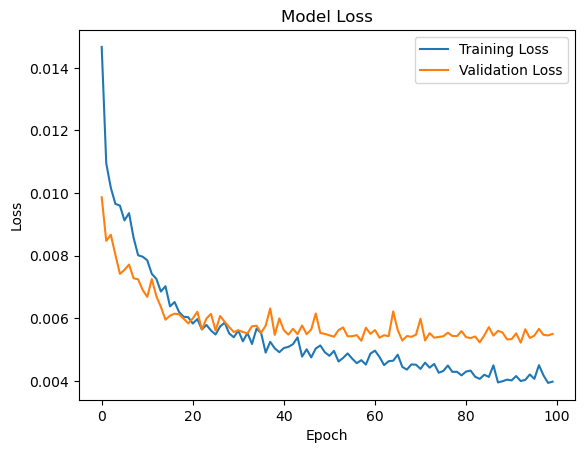

In [29]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

10/10 [==============================] - 0s 8ms/step


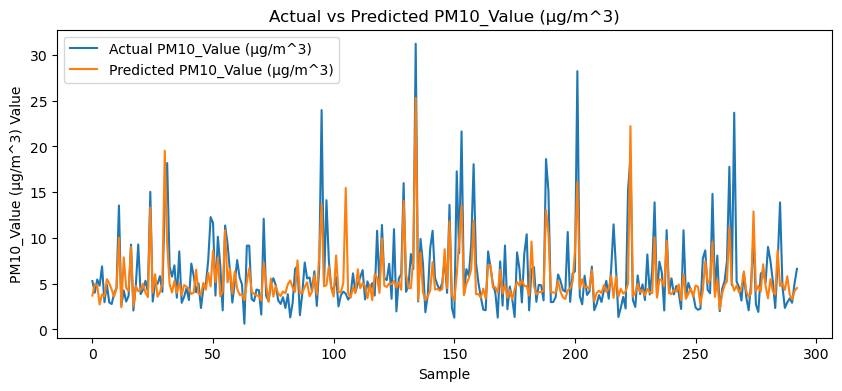

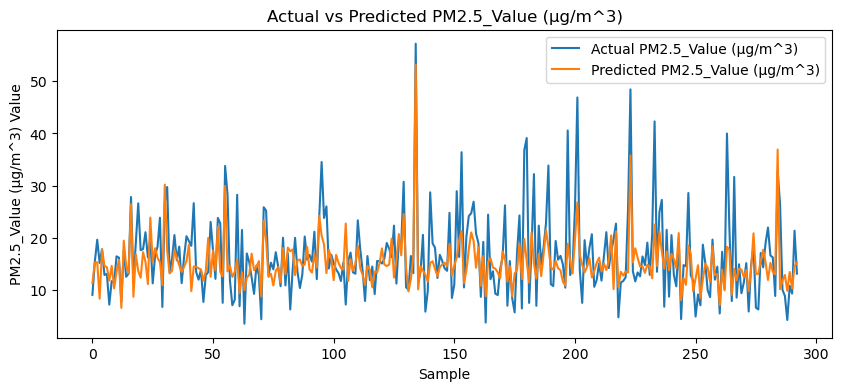

In [30]:

predictions = model.predict(X_test)


predictions_inversed = scaler.inverse_transform(predictions)
y_test_inversed = scaler.inverse_transform(y_test)


target_labels = ['PM10_Value (µg/m^3)', 'PM2.5_Value (µg/m^3)']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel(f'{target_labels[i]} Value')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

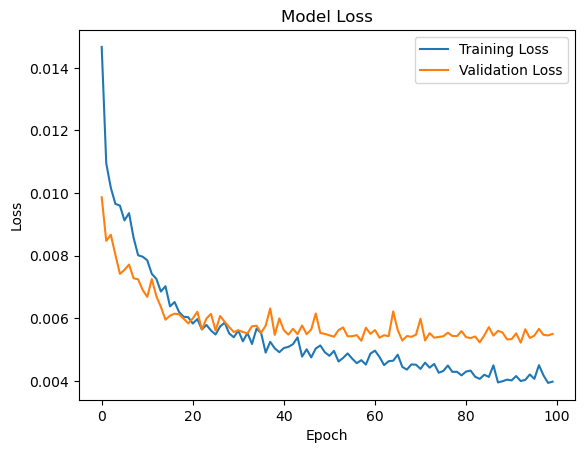

In [31]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [32]:

y_pred = model.predict(X_test)


mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

10/10 [==============================] - 0s 7ms/step
Mean Absolute Percentage Error (MAPE): 35.32897291038927 %


In [33]:
print(bdf.head())


first_row = bdf.iloc[0]
print("第一行数据：")
print(first_row)

                  Date  Daily Average CO (mg/m3)  Daily Average NO (ug/m3)  \
0  1577836800000000000                  0.246304                 29.073479   
1  1577923200000000000                  0.271630                 25.823044   
2  1578009600000000000                  0.251587                 32.285652   
3  1578096000000000000                  0.101152                 12.457826   
4  1578182400000000000                  0.153565                 15.993478   

   Daily Average NO2 (ug/m3)  Daily Average SO2 (ug/m3)  \
0                  21.320869                   2.464783   
1                  16.736956                   2.589130   
2                  20.269566                   2.274348   
3                  11.590435                   1.893044   
4                  13.545217                   2.067391   

   Daily Average PM2.5 (ug/m3)  Daily Average PM10 (ug/m3)  WDir(Deg)  \
0                     9.883333                   25.904167       35.0   
1                    14.966667

In [34]:
model.save('christchurch_cnnlstm.h5') 

D:\Anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
print(bdf.columns.tolist())

['Date', 'Daily Average CO (mg/m3)', 'Daily Average NO (ug/m3)', 'Daily Average NO2 (ug/m3)', 'Daily Average SO2 (ug/m3)', 'Daily Average PM2.5 (ug/m3)', 'Daily Average PM10 (ug/m3)', 'WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)', 'Rain(mm)', 'Tdry(C)', 'TWet(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)', 'Pmsl(hPa)', 'Pstn(hPa)', 'Rad(MJ/m2)', 'lightCount', 'heavyCount']


In [40]:

predict_features_columns = ['Date', 'Daily Average CO (mg/m3)', 'Daily Average NO (ug/m3)', 
                            'Daily Average NO2 (ug/m3)', 'Daily Average SO2 (ug/m3)', 'WDir(Deg)', 
                            'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)', 'Rain(mm)', 
                            'Tdry(C)', 'TWet(C)', 'RH(%)', 'Tmax(C)', 'Tmin(C)', 'Pmsl(hPa)', 
                            'Pstn(hPa)', 'Rad(MJ/m2)', 'lightCount', 'heavyCount']


sample = bdf.iloc[10]

sample_features = sample[predict_features_columns]


sample_features_df = pd.DataFrame([sample_features])

scaled_sample_features = scaler.transform(sample_features_df)


scaled_sample_features = scaled_sample_features.reshape((1, scaled_sample_features.shape[1], 1))

prediction = model.predict(scaled_sample_features)


print("Predicted target values:", prediction)





ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Daily Average CO (mg/m3)
- Daily Average NO (ug/m3)
- Daily Average NO2 (ug/m3)
- Daily Average SO2 (ug/m3)
- Date
- ...
Feature names seen at fit time, yet now missing:
- Daily Average PM10 (ug/m3)
- Daily Average PM2.5 (ug/m3)


In [ ]:
original_scale_prediction = output_scaler.inverse_transform(prediction)


print("反缩放后的预测目标值:")
print(original_scale_prediction)